In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import pathlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 3]
plt.rcParams['figure.dpi'] = 150

import os
import sys
os.chdir('..')
sys.path.insert(0, '..')

from trlfpi.report import Report

In [2]:
def importExperimentData(experiment: str):
    path = pathlib.Path(f"results/{experiment}")
    
    data = []
    for x in path.iterdir():
        report = Report(experiment, x.parts[-1])
        variables = report.unpickle('variables')
        evalResults = report.unpickle('evalResults')
        args = report.getArgs()
        data.append((args, variables, evalResults))

    return data

In [3]:
def plotExpData(data, title):

    rewardData = np.vstack(list(map(lambda x: x[1]['rewards'][0], data)))
    
    akey = 'actorLoss' if 'actorLoss' in data[0][1] else 'actor_loss'
    actorLoss = np.vstack(list(map(lambda x: x[1][akey][0], data)))

    ckey = 'criticLoss' if 'criticLoss' in data[0][1] else None
    ckey = 'critic_loss' if 'critic_loss' in data[0][1] else None
    if ckey:
        criticLoss = np.vstack(list(map(lambda x: x[1][ckey][0], data)))
    
    if ckey:
        fig, axs = plt.subplots(4, 1, sharex=True, figsize=(20,12))
        axs[3].plot(criticLoss.T)
        axs[3].set_ylabel('loss')
        axs[3].set_ylim((-10, 50000))
        axs[3].set_title('Critic loss')
        axs[3].grid()
    else:
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 9))
    
    fig.suptitle(title)
    axs[0].plot(rewardData.T)
    axs[0].set_ylabel('reward')
    axs[0].set_ylim((-10000, 10))
    axs[0].set_title('Experiment reward')
    axs[0].grid()
    
    axs[1].plot(np.mean(rewardData, axis=0))
    axs[1].set_ylabel('mean reward')
    axs[1].set_title('Mean experiment reward')
    axs[1].grid()
    
    axs[2].plot(actorLoss.T)
    axs[2].set_ylabel('loss')
    axs[2].set_title('Actor loss')
    axs[2].grid()
    
    return fig, np.mean(rewardData, axis=0)

In [4]:
def resultsTable(name, data):
    rewardData = np.array(list(map(lambda x: x[2]['meanReward'], data)))
    rewardStats = {
        'name' : name,
        'mean' : rewardData.mean(),
        'std' : rewardData.std(),
        'best' : rewardData.max(),
        'under1' : np.sum(rewardData > -1),
        'under5' : np.sum(rewardData > -5)
    }
    print(f"{name} mean reward : {rewardStats['mean']}")
    print(f"{name} std reward : {rewardStats['std']}")
    print(f"{name} best reward : {rewardStats['best']}")
    print(f"{name} # under 1: {rewardStats['under1']}")
    print(f"{name} # under 5: {rewardStats['under5']}")
    return rewardStats

In [5]:
from IPython.display import IFrame

def displayPDF(path: str):
    display(IFrame(path, width=100, height=100))

## Env

For testing, a simple linear environment with a randomly generated reference during each episode. While using always using the same reference might be more adecuate/better fitting for the ultimate goal, I belive that by doing this, the policy will actually learn the system dynamics instead of blindly repeating the same every time.

$$ \underline x_{k+1} =  A \cdot \underline x_k + B \cdot \underline u_k $$

## Reinforce with baseline

Implentation of the reinforce algorithm with unbiased rewards, on-policy, experience replay and importance sampling.

$$\nabla_\theta J(\theta) = \sum^{\mathcal D}  \omega \cdot (c^{(i)} - \overline c) \cdot \nabla_\theta \ln \pi_\theta(u^{(i)} | x^{(i)}, r^{(i)})  $$
$$\omega = \frac{\pi_\theta(u^{(i)} | x^{(i)}, r^{(i)})}{\pi'_\theta(u^{(i)} | x^{(i)}, r^{(i)})}$$

Baseline is calculated by calculated the mean cost in the batch $\overline c = \frac{1}{|\mathcal D|} \sum^{\mathcal D} c_i$. At the time of sampling, the probability $\pi'$ of the action is saved to weight its importance for the current policy update. 

The actor network is updated every timestep. The target network is used for generating samples from the env, and at the end of every episode, it copies the parameters from the actor network.

### Analysis
**Pro**
 - Only one approximator (Policy) (less hyperparams, less resorce intensive)
 - Able to learn on continuos action environments (All policy gradient algorithms)
 - Easy to apply on and off policy
 - It doesn't depend on the quality of another model to learn properly

**Cons**
 - Unstable learning progress, not guaranteed to converge
 - Has to save full trajectories to use discounted rewards


In [6]:
reinforceData = importExperimentData('REINFORCE')

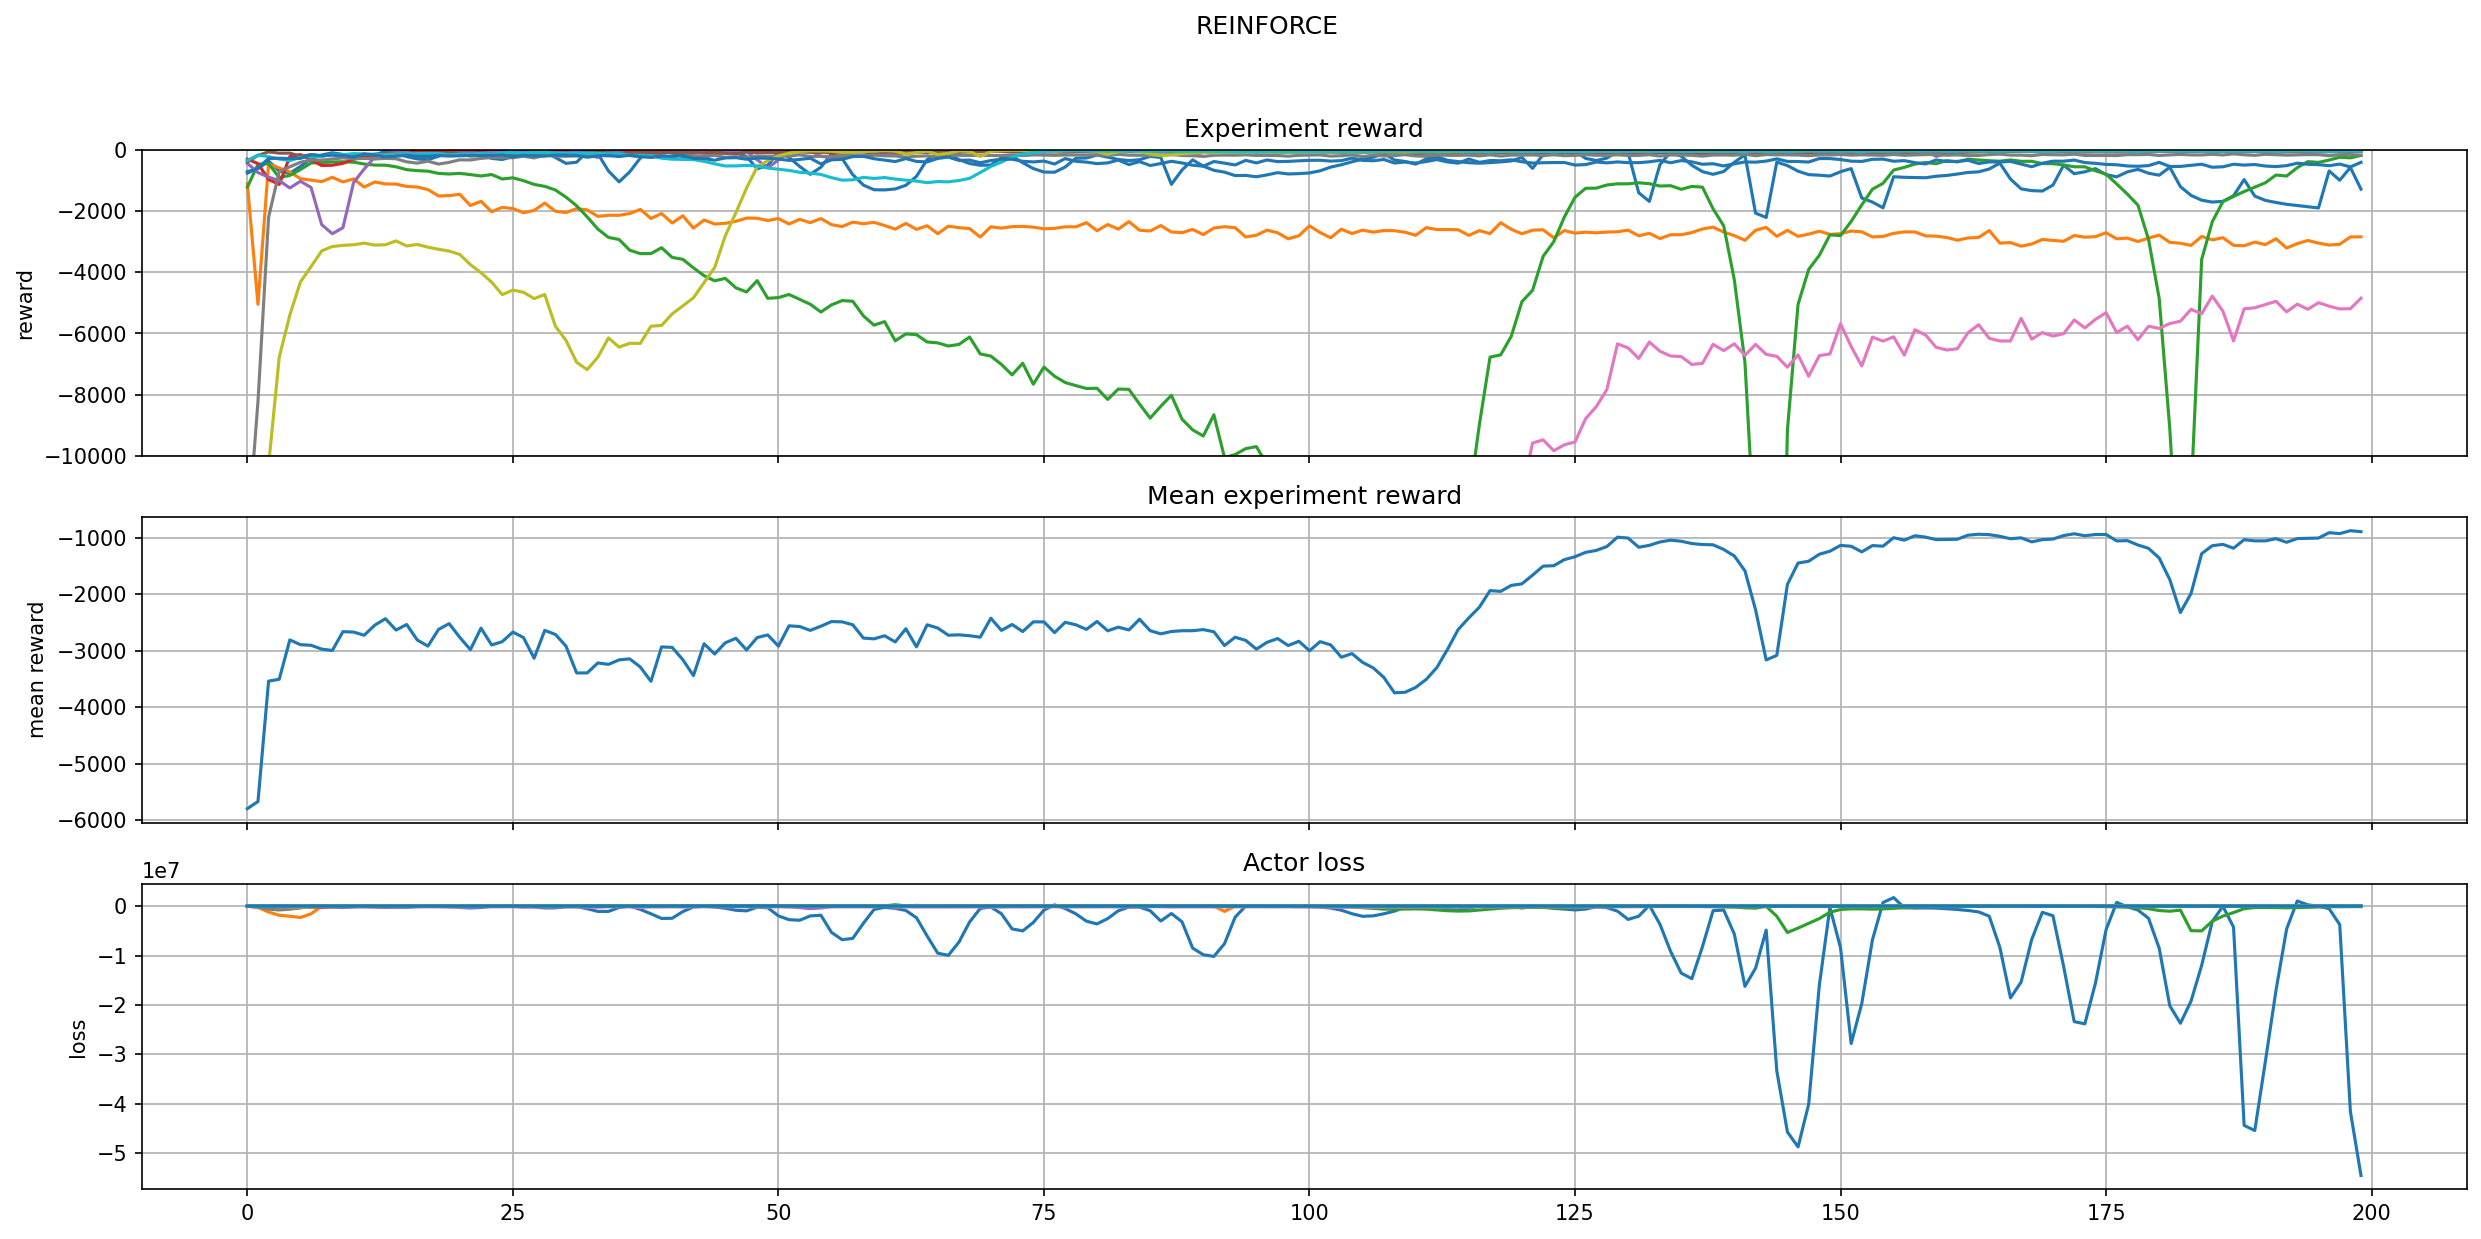

In [7]:
fig, reinforceMean = plotExpData(reinforceData, 'REINFORCE')
fig

In [8]:
reinforceStats = resultsTable('REINFORCE', reinforceData)

REINFORCE mean reward : -455.7885092826657
REINFORCE std reward : 1156.09373007422
REINFORCE best reward : -0.22156307652214458
REINFORCE # under 1: 2
REINFORCE # under 5: 3


## Actor-Critic

Same principle as the policy gradient, but the advantage term uses an approximation of the Q and Value function to give a better estimate of the expected reward given an action. Q-Function critic is trained using temporal differences error. Like for REINFORCE, a replay buffer and a target network are used to maintain stability during training. 

$$ C(\phi) = \sum^{\mathcal D} \left( c^{(i)}_t + \gamma Q_{\phi'}(u_{t+1}, x_{t+1}^{(i)}, r^{(i)}) - Q_{\phi}(u_t^{(i)}, x_t^{(i)}, r^{(i)}) \right)^2 |_{u_{t+1} = \pi'} $$

The updates are done a every step, just like with reinforce. The gradient of the policy function is updated to this.

$$\nabla_\theta J(\theta) = \sum^{\mathcal D} \omega \cdot  A \cdot \nabla_\theta \ln \pi_\theta(u^{(i)} | x^{(i)}, r^{(i)}) $$

$$ A = Q_\phi (u^{(i)}, x^{(i)}, r^{(i)}) - V(x^{(i)}, r^{(i)}) $$

The value function is calculated by sampling many (200) actions from the current policy and calculating the mean from the resulting Q values.
To update the target networks, instead of a hard copy like in reinforce, a soft update is used every 2 steps. 

$$ \theta' = (1 - \tau) \cdot \theta' + \tau \cdot \theta $$

$\tau$ is set to 0.001 for all experiments.

### Analysis
**Pro**
 - Provides a more stable learning process thanks to the Q-Function
 - Q-Function automaticly learns discounted rewards TD Error, providing it to the policy without saving full (or partial trajectories)
 - Provides (with enought time) better results than REINFORCE

**Cons**
 - Slow learning to guarantee stability of Q-Function during training
 - Policy only learns properly once (and if) the critic has learnt something

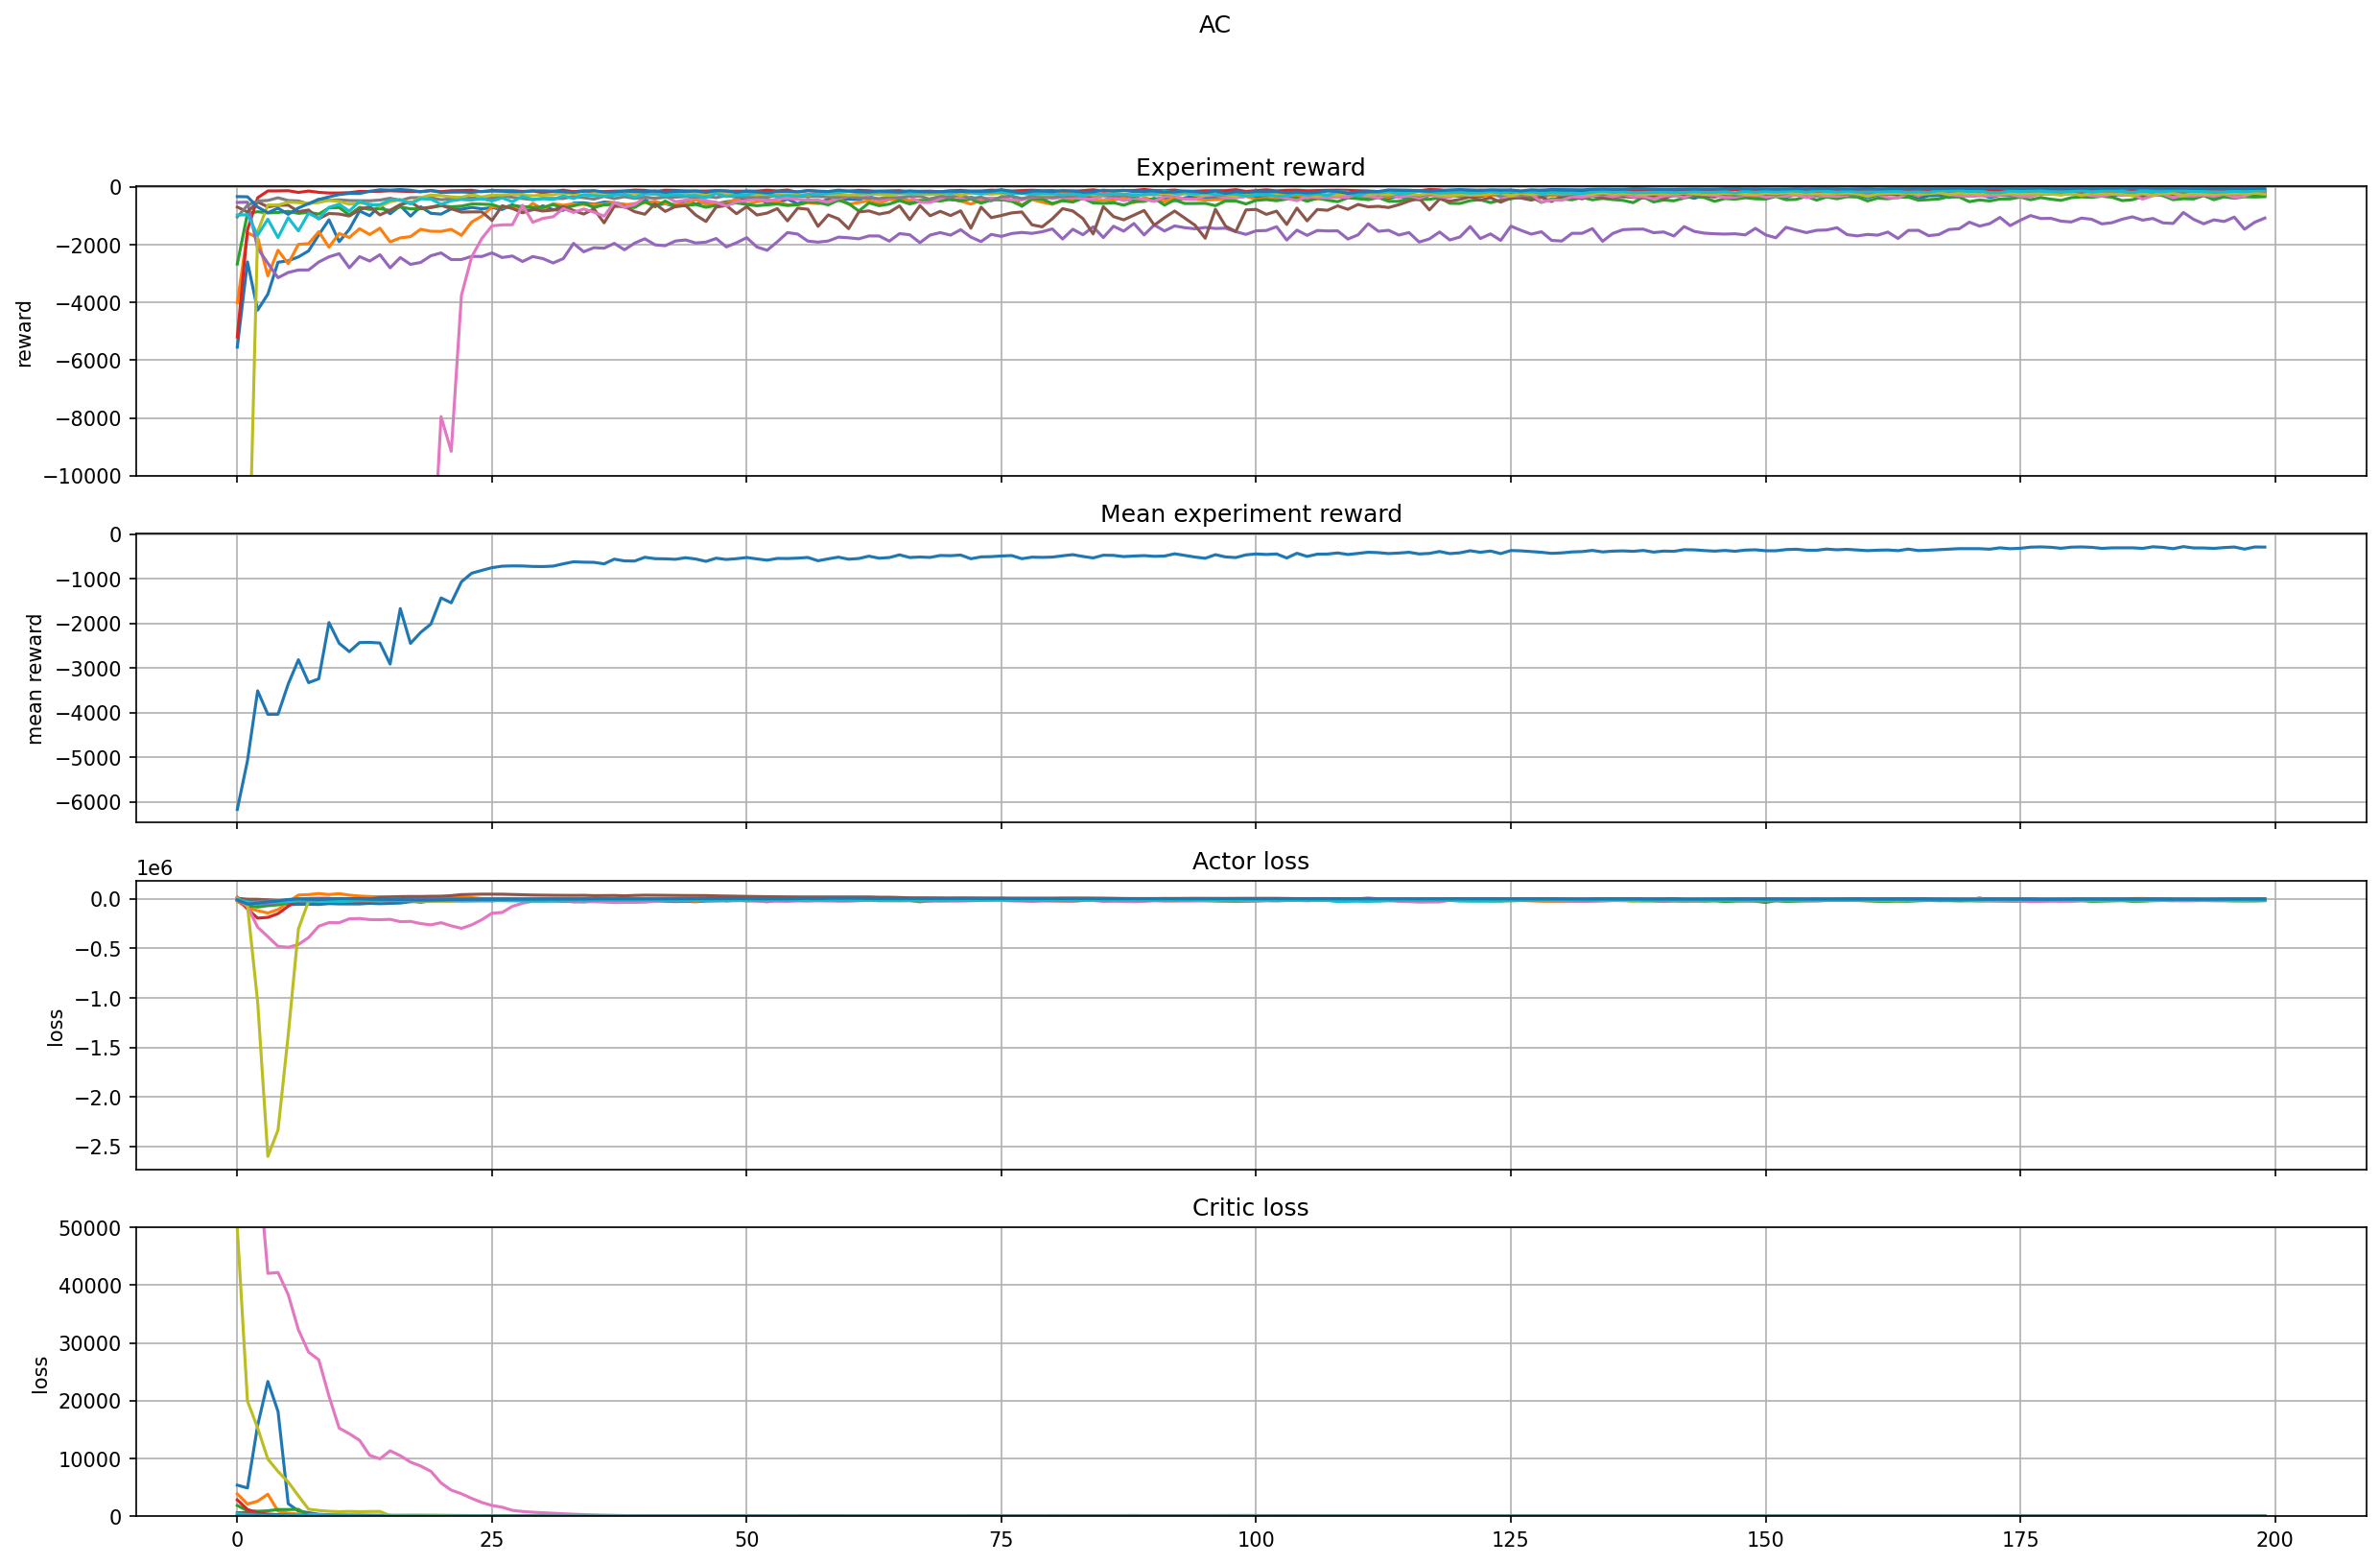

In [9]:
acData = importExperimentData('AC')
fig, acMean = plotExpData(acData, 'AC')
fig

In [10]:
acStats = resultsTable('AC', acData)

AC mean reward : -232.3075069790143
AC std reward : 558.8212808145927
AC best reward : -25.013295636302747
AC # under 1: 0
AC # under 5: 0


## DPG

DPG uses a deterministic policy, and it tries to update it by directly maximizing the Q-Function return.

$$ \nabla_\theta J(\theta) = \sum^{\mathcal D} \nabla_a Q_\phi(u, x^{(i)}, r^{(i)}) \nabla_\theta \mu_\theta(x^{(i)}, r^{(i)}) |_{u = \mu_\theta} $$

Again, the implementation uses target networks and replay buffers. The main difference is that exploration is done by applying noise to the policy during sampling in the form of $u_t = \mu(x_t, r_t) + \sigma \cdot \mathcal N(0, 1)$.

### Analisys
**Pros**
 - For now, best performing algorithm
 - Simpler policy (doesn't require variance params)
 - Fastest convergence
 
**Cons**

 - Only allows deterministic policies ( exploration policy is needed in order to explore)


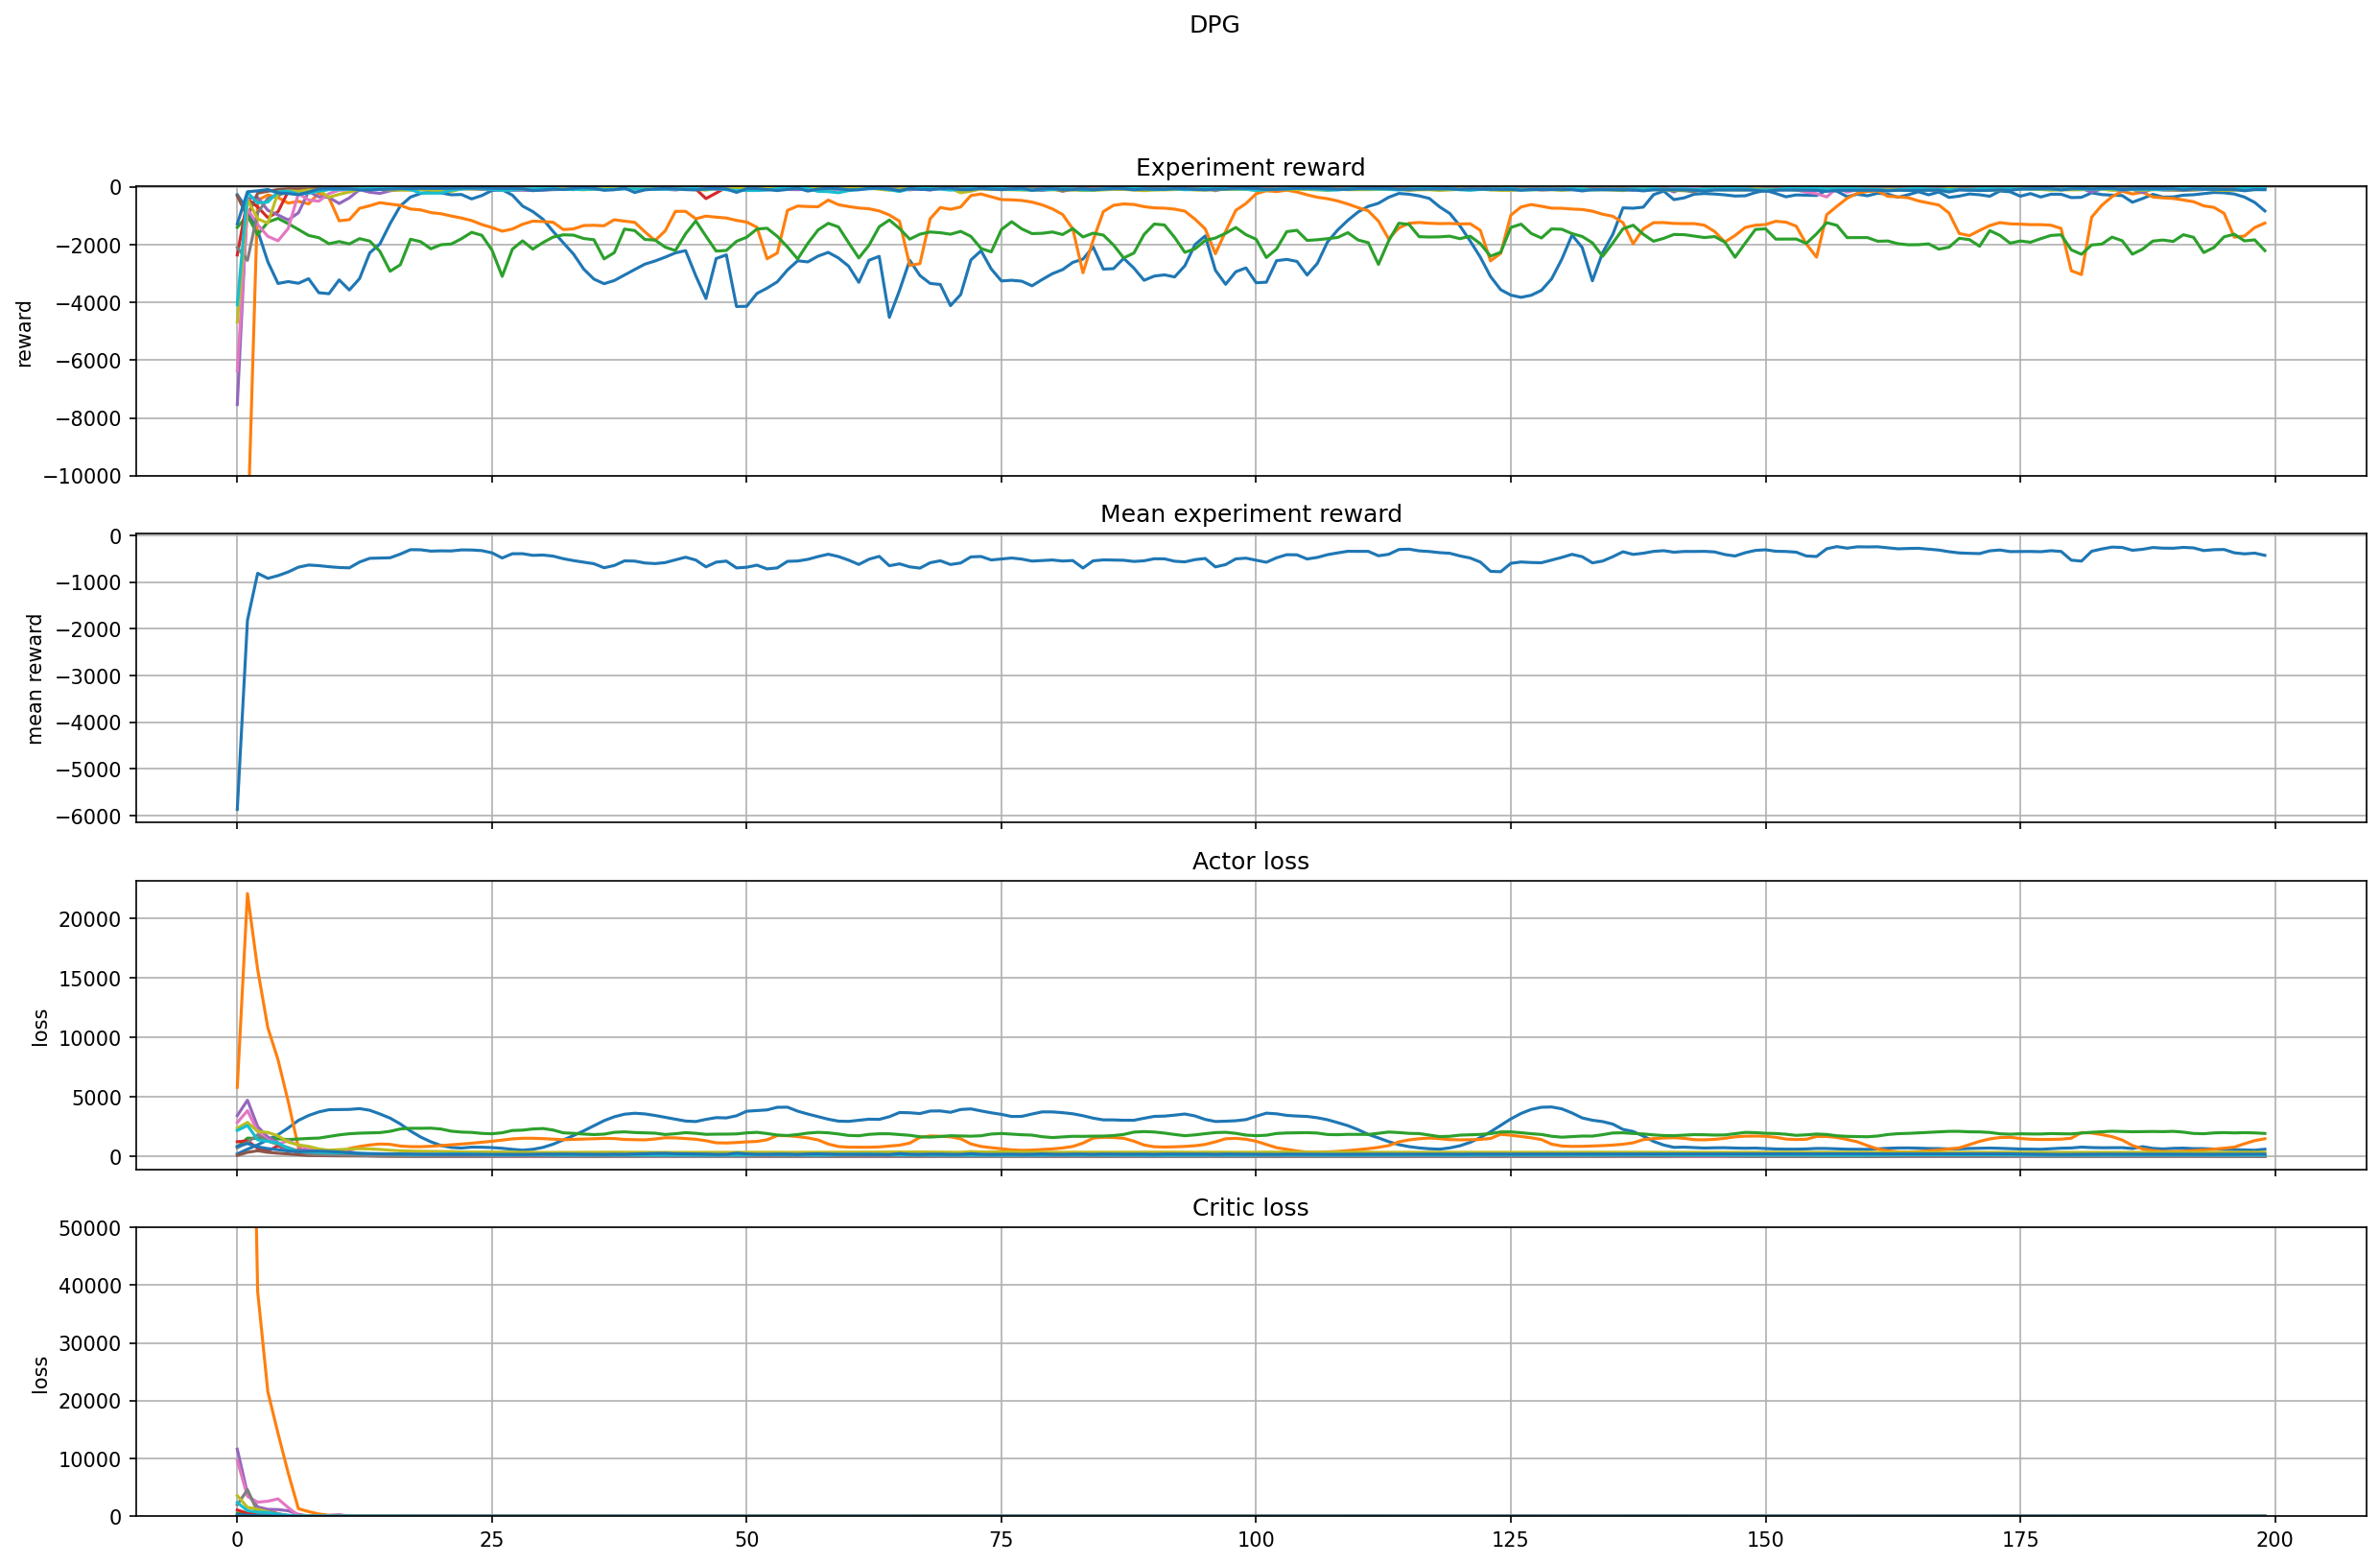

In [11]:
dpgData = importExperimentData('DPG')
fig, dpgMean = plotExpData(dpgData, 'DPG')
fig

In [12]:
dpgStats = resultsTable('DPG', dpgData)

DPG mean reward : -195.48952623813094
DPG std reward : 559.100359501424
DPG best reward : -0.2882373673013595
DPG # under 1: 3
DPG # under 5: 4


## MBACD

In order to take advantage of a system model and the reference trajectory, our algorithm uses different inputs for the policy and Q function.

### System model

$$g(\underline x_k, \underline u_k) \sim GP(\mu([\underline x_k, \underline u_k]^T), k([\underline x_k, \underline u_k]^T, [\underline x, \underline u_k]^T)) $$

### Policy function

The policy function takes the following form.

$$\pi_\theta( \underline u \ |\  \underline x, \underline r) = \mathcal{N}(\mu_\theta(\underline z), \sigma_\theta(\underline z))$$

Again we use a stochastic policy, a Normal distribution parametrised by $\mu(\underline z)$ and $\sigma (\underline z)$, with $\underline z_k = [r_{k+1} - x_k, ..., r_{k+h} - x_k]$. Doing this has the benefit of reducing the range of input dimensions and centering it around zero, which is similar to the input normalization used in many deep learning applicaitons. It also puts an enfasis on the change is has to make to reach the next reference, instead of on the current absolute state, which might help it generalize to unknow states. Another benefit is the reduction of the number of inputs, reducing it by one, reducing the number of parameters of the network.

The objective policy gradient takes the following form.

$$\nabla_\theta J(\theta) = \sum^{D} \omega \cdot A \cdot \nabla_\theta \ln \pi(\underline u | \underline z) $$

In this case the advantage function is the only the Q-Function.

### Q-Function

The Q function is also enhanced with more input information. Similar to the inputs of the policy, we use the difference from the reference to the future predicted states. 

$$ \underline \epsilon_{k+1} = \underline r_{k+1} - \underline x_{k+1} $$
$$ \underline \epsilon_{k+1} = \underline r_{k+1} - g(\underline x_k, \underline u_k)$$

The Q function being an approximation of the future expected rewards of the policy, it makes sense that by providing the projected future deviations, it could make a better judgment on the quality of the current state-action pair. This is only sensible in a discounted reward scenario, were the future rewards influence the current Q value. 

$$ \underline d = \left [\underline u_k^T, \underline \epsilon_{k}^T, \underline \epsilon_{k+1}^T, ..., \underline \epsilon_{k+h}^T, \right ]^T $$

$$ Q_\phi (\underline d) $$

The reason the advantage function is only the Q-Function is that to calculate the value function in a similar fashion as on the AC Algorithm, one would need to calculate multiple future actions and states depending on the amount of samples drawn to aproximate the expected value based on the initial action. This would slow down training, and I belive is not the main problem this algorithm has right now.

### Training

Excluding the inputs of both functions, the training is equal to the Actor Critic algorithm from before. (Importance sampling, replay buffers, target networks)

### Analisys
**Pros (allegedly)**
 - Policy and Q-Function requiere only distant from reference (better generalization in unknown states)
 - Usage of predicted future error, to make better predictions of expected discounted reward
 - Uses the predictions in the input instead of directly backpropagating through them (model predictive control/imagination rollouts) (less operations, avoids vanishing/exploding gradient)

**Cons**
 - Requieres system model
 - Extra operations during training to predict h future states
 - Only usable with system references
 - If reference doesn't cover full state, leads to extremely ugly code and formulas
 
Clearly the critic is not learning
 
**Why?**
 
 - Error in code
 - Best reward when $Q(u_k, 0, 0, 0)$, which might be the reson is not converging
 - Network might be to small to, needs to be bigger for the extra inputs
 - 

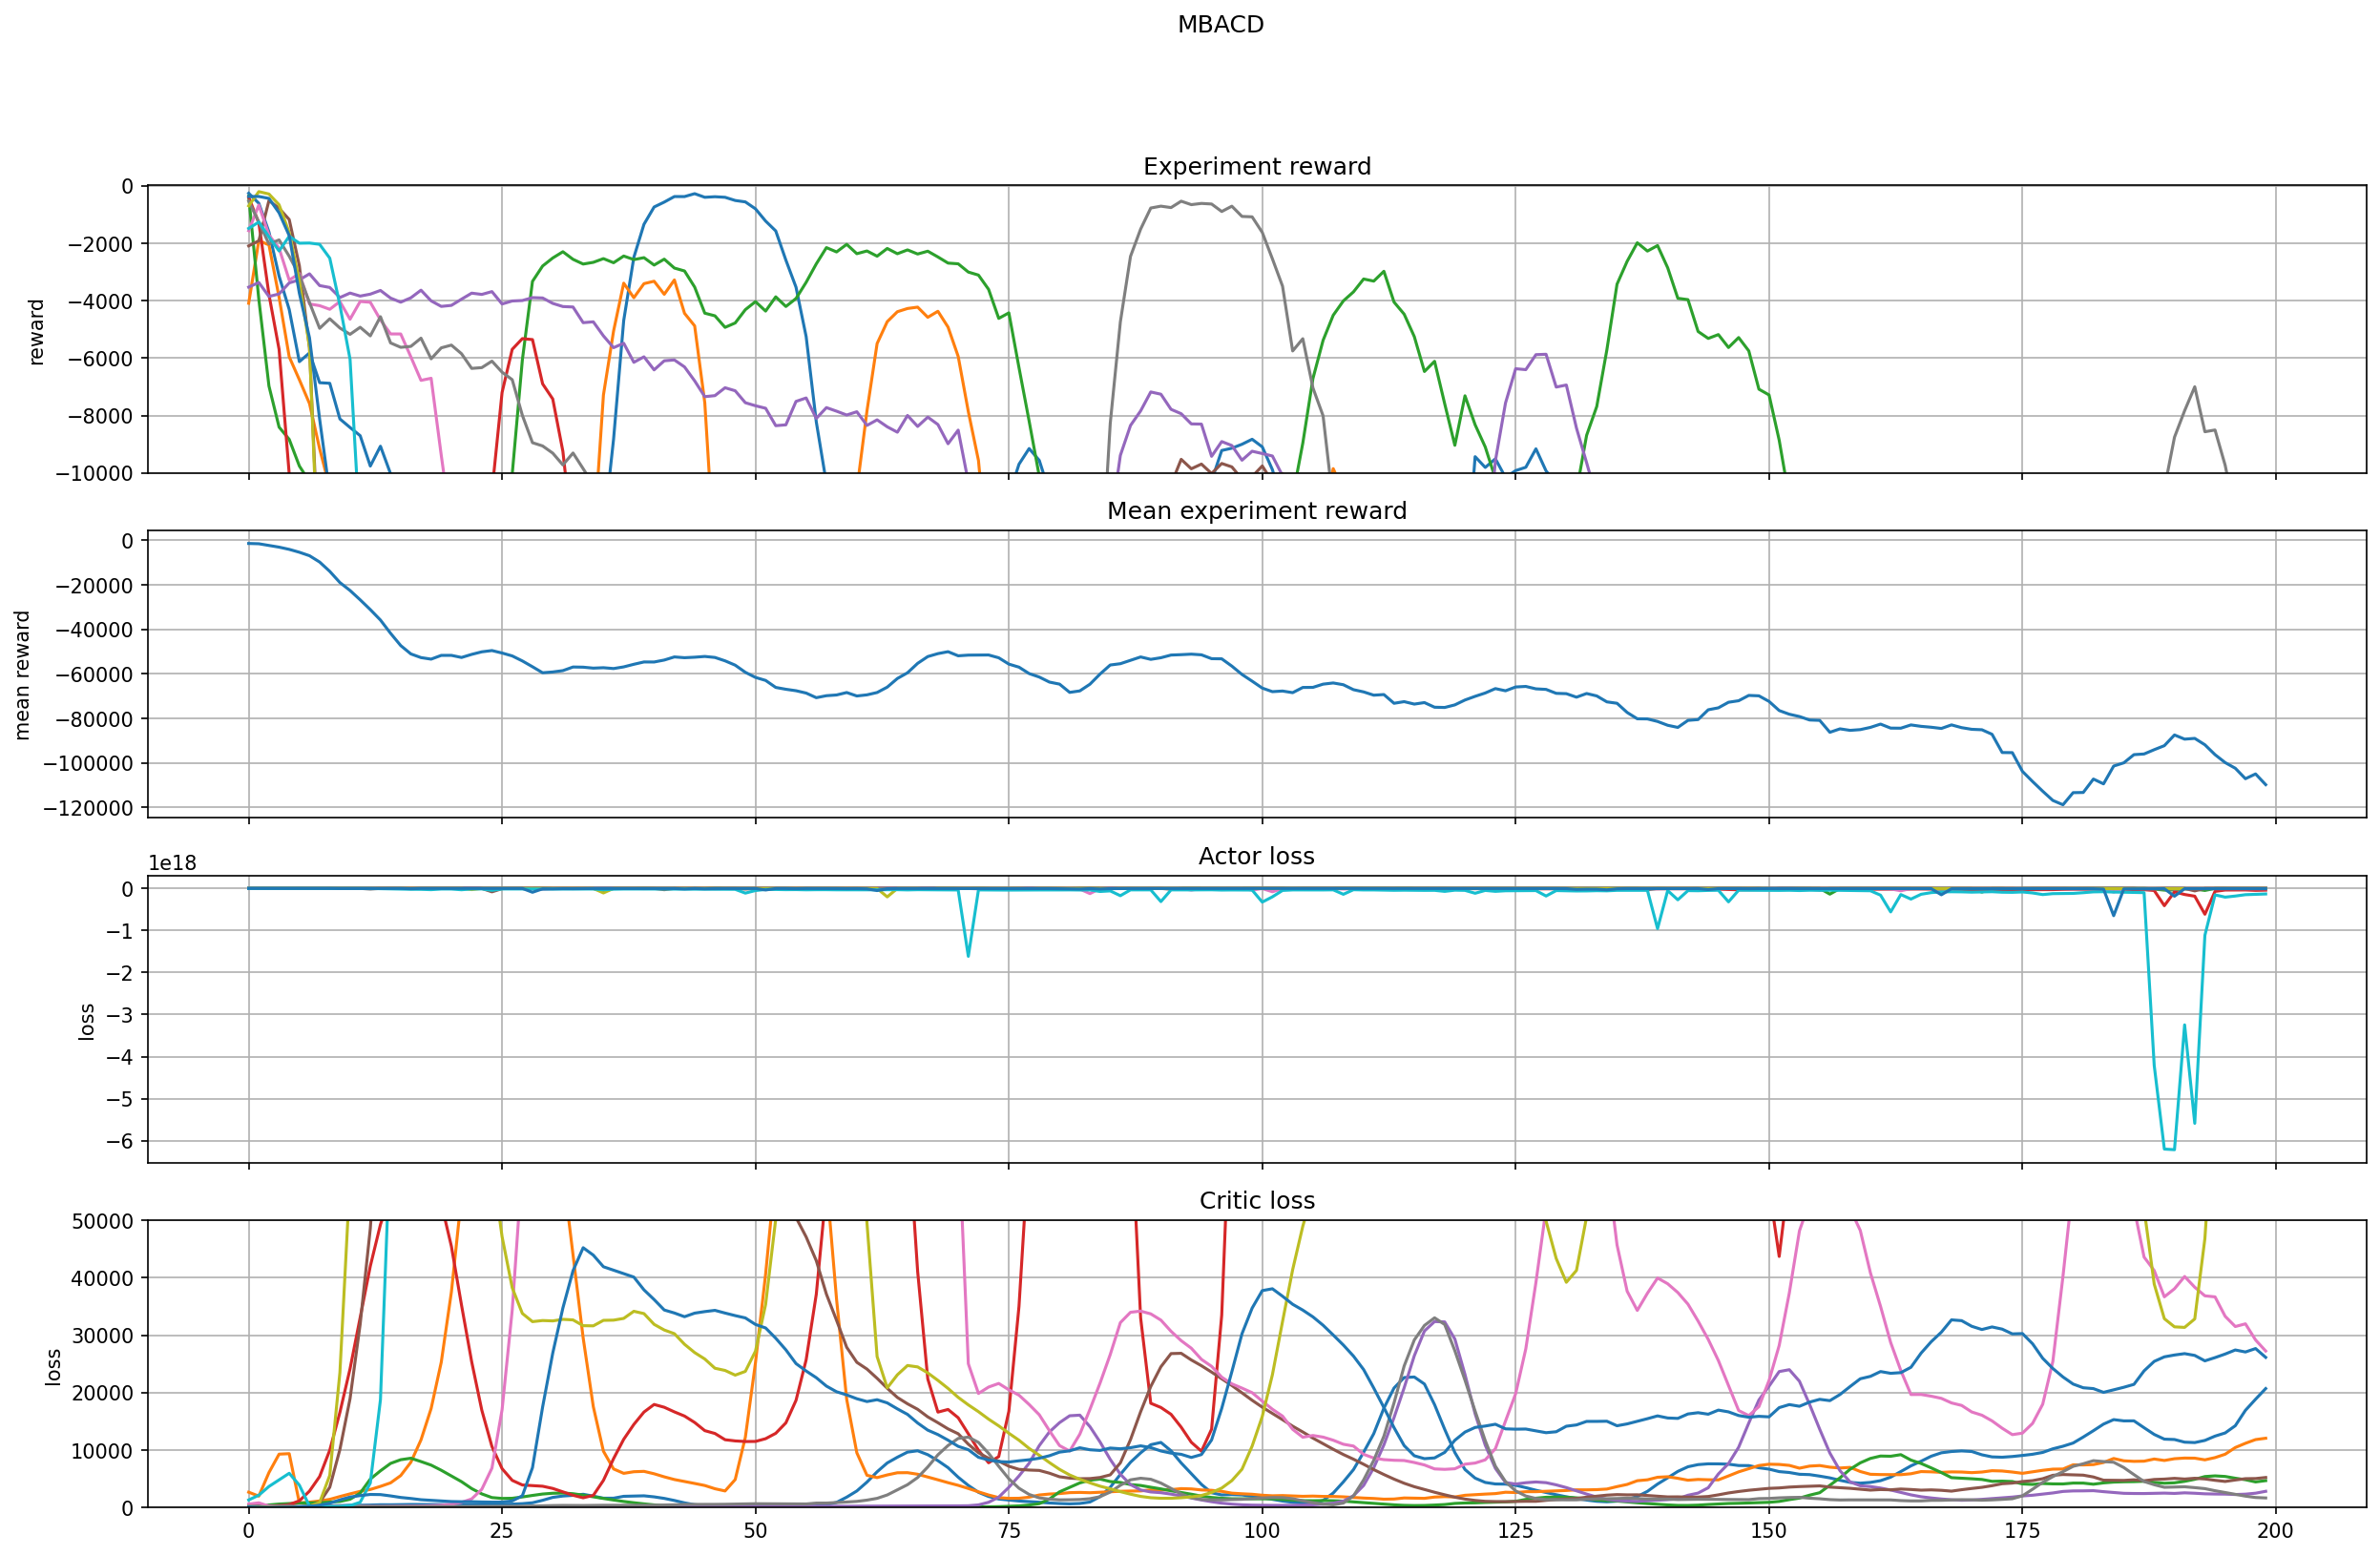

In [13]:
mbacdData = importExperimentData('MBACD')
fig, mbacdMean = plotExpData(mbacdData, 'MBACD')
fig

In [14]:
mbacdStats = resultsTable('MBACD', mbacdData)

MBACD mean reward : -1760.5598051685724
MBACD std reward : 2543.801269633103
MBACD best reward : -64.47958622468511
MBACD # under 1: 0
MBACD # under 5: 0


## Results table

In [15]:
resultsDF = pd.DataFrame([reinforceStats, acStats, dpgStats, mbacdStats])
resultsDF

,name,mean,std,best,under1,under5
0,REINFORCE,-455.788509,1156.093730,-0.221563,2,3
1,AC,-232.307507,558.821281,-25.013296,0,0
2,DPG,-195.489526,559.100360,-0.288237,3,4
3,MBACD,-1760.559805,2543.801270,-64.479586,0,0


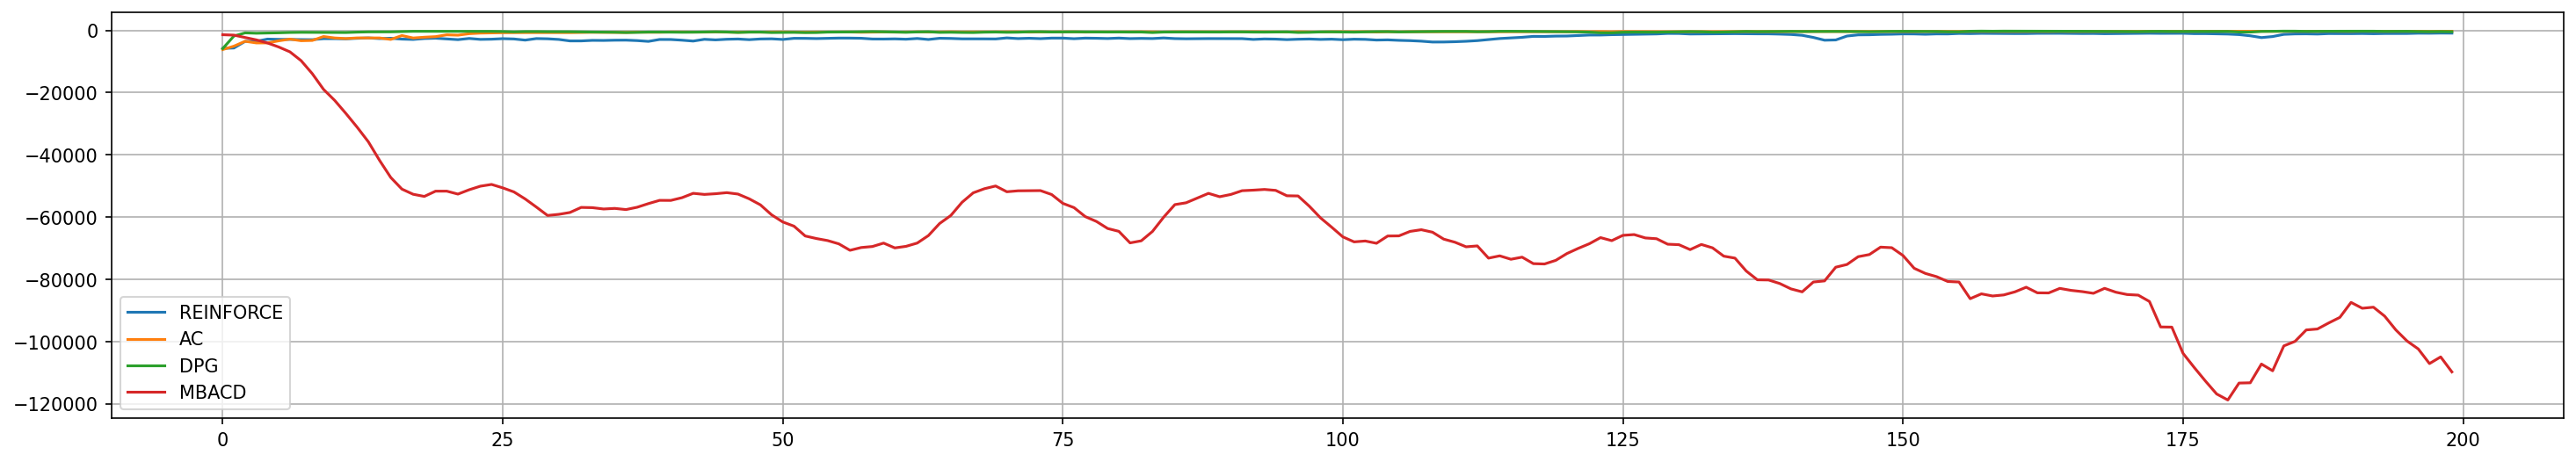

In [16]:
plt.rcParams['figure.figsize'] = [24, 4]
fig, axs = plt.subplots(1, 1)
axs.plot(reinforceMean, label='REINFORCE')
axs.plot(acMean, label='AC')
axs.plot(dpgMean, label='DPG')
axs.plot(mbacdMean, label='MBACD')
axs.legend()
axs.grid()
fig

## Stochastic Q-Function Gradients

This method is an attempt of combining the MBACD methods with DPG. The policy and the Q-Function inputs/parametrization are identical to the MBACD algorithm. The improvement (maybe?) relies on the calculating the gradient directly from the Q-Function, similar to DPG.

$$ \nabla_\theta J(\theta) = \sum^{\mathcal D} \nabla_{u_k} Q_\phi(\underline d) \nabla_\theta \pi_\theta(\underline z_k) |_{u_k = \pi_\theta} $$

This formula would take advantage of the more stable deterministic policy gradient idea of directly maximazing the reward of the Q-Function by backpropagating through it. But, because of the input of the Q-Function depends on almost all its inputs on the selected action $u_k$, the backpropagation is procedure is also different.

$$ \frac{\partial Q_\phi (\underline d)}{\partial u_k} = \frac{\partial Q_\phi (\underline d)}{\partial \underline d} \cdot \frac{\partial \underline d}{\partial u_k} $$

The first part of the operation is the same backprogation through the network, which is standart in any Deep Learning/Neural Network and doesn't require much explanation. 

$$ \frac{\partial \underline d}{\partial u_k} = \left [ 1, 0, -\frac{\partial g(\underline x_{k}, \underline u_{k})}{\partial \underline u_k},  -\frac{\partial g(\underline x_{k+1}, \underline u_{k+1})}{\partial \underline x_{k+1}} \cdot \frac{\partial g(\underline x_{k}, \underline u_{k})}{\partial \underline u_k}, ...\right ]$$

The gradient of this Q-Function takes not only into account the effects the policy has based on the current state (and indirectly on the discounted future rewards). Here, the future decisions that will be taken by the policy are also taken into account for the update. This steps puts a requirement on the system model, as it should be differentiable to backpropagate to it. GP are ideal for that reason. 

Idealy, because the future rewards are discounted, the effect of those extra gradient steps would be proportional. Some fine tuning of the discount factor might be necessary, or applying it directly in the gradient process. 

It also depends on the Q-Function learning, which is not the case :(